In [1]:
import torch
import numpy as np 
import scipy

import matplotlib.pyplot as plt
import spatial_maps as sm

from tqdm import tqdm
from models import FFGC, RNNGC
from dataset import DatasetMaker
from plotting_functions import *

In [2]:
def smooth(ratemaps, sigma):
    return scipy.ndimage.gaussian_filter(ratemaps, sigma, axes = (-2, -1))

def vonmises_kde(data, kappa, n_bins=100):
    # https://stackoverflow.com/questions/28839246/scipy-gaussian-kde-and-circular-data
    bins = np.linspace(-np.pi, np.pi, n_bins)
    x = np.linspace(-np.pi, np.pi, n_bins)
    # integrate vonmises kernels
    kde = np.exp(kappa*np.cos(x[:, None]-data[None, :])).sum(-1)/(2*np.pi*scipy.special.i0(kappa))
    kde /= np.trapz(kde, x=bins)
    return bins, kde

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if feedforward := False:
    # instantiate feedforward model
    model_type = "FF"
    model = FFGC()
    model = model.load(f"./saved-models/{model_type}GC_100000.pkl")
else:
    model_type = "RNN"
    model = RNNGC()
    model = model.load(f"./saved-models/{model_type}GC_49999.pkl")
model.to(device)

RNNGC(
  (rg): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
  )
  (relu): ReLU()
  (gg): Linear(in_features=256, out_features=256, bias=False)
  (vg): Linear(in_features=2, out_features=256, bias=False)
)

In [4]:
res = 64

if feedforward:
    # evaluate on 64x64 grid
    x = np.linspace(-1, 1, res)*2*np.pi
    y = np.linspace(-1, 1, res)*2*np.pi
    xx, yy = np.meshgrid(x,y)
    r = np.stack([xx.ravel(), yy.ravel()], axis = -1)
    gs = model(torch.tensor(r.astype("float32"),device = device))
    gs = gs.detach().cpu().numpy()
    gs = gs.T.reshape(-1,res,res)
    gs.shape
else:
    timesteps = 10
    dataset = DatasetMaker()
    rt, vt = dataset.generate_data(50000, timesteps)
    g = model((rt[:,0], vt)).detach().numpy() # double check that states are alright
    gs = scipy.stats.binned_statistic_2d(rt[...,0].ravel().numpy(), rt[...,1].ravel().numpy(), g.reshape(-1, g.shape[-1]).T, bins = res)[0]

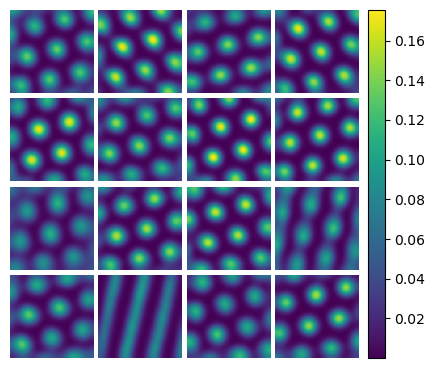

In [5]:
smooth_ratemaps = smooth(gs, 2)
multiimshow(smooth_ratemaps[:16], figsize=(4,4));

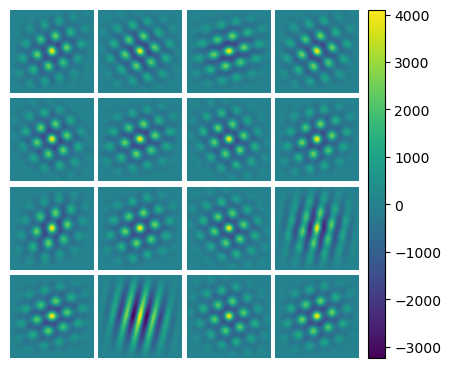

In [6]:
acorrs = np.array([sm.autocorrelation(ratemap) for ratemap in smooth_ratemaps])
multiimshow(acorrs[:16], figsize=(4,4));

In [7]:
grid_score = np.array([sm.gridness(gs[i]) for i in range(len(gs))])
np.save(f"./statistics/{model_type}_Grid Score.npy", grid_score)


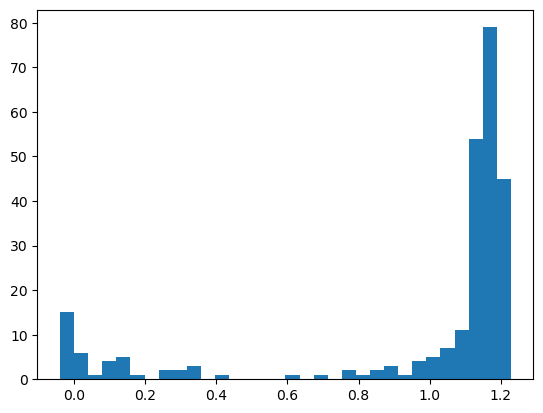

In [8]:
plt.hist(grid_score, bins = 32);

In [9]:
grid_score_mask = grid_score > -1
acorrs = acorrs[grid_score_mask]
smooth_ratemaps = smooth_ratemaps[grid_score_mask]
peaks = [sm.find_peaks(acorr) for acorr in acorrs]

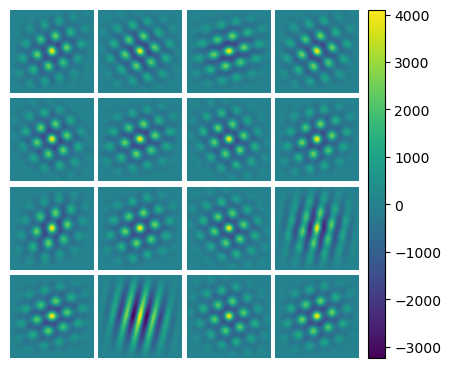

In [10]:
multiimshow(acorrs[:16], figsize=(4,4)); # show after selection, too

In [11]:
thetas = np.array([sm.spacing_and_orientation(peak, acorrs.shape[-1])[1] for peak in peaks])
spacings = np.array([sm.spacing_and_orientation(peak, acorrs.shape[-1])[0] for peak in peaks])
spacings = spacings*4*np.pi/acorrs.shape[-1] # scale to box size
np.save(f"./statistics/{model_type}_Spacing.npy", spacings)
np.save(f"./statistics/{model_type}_Orientation.npy", thetas)

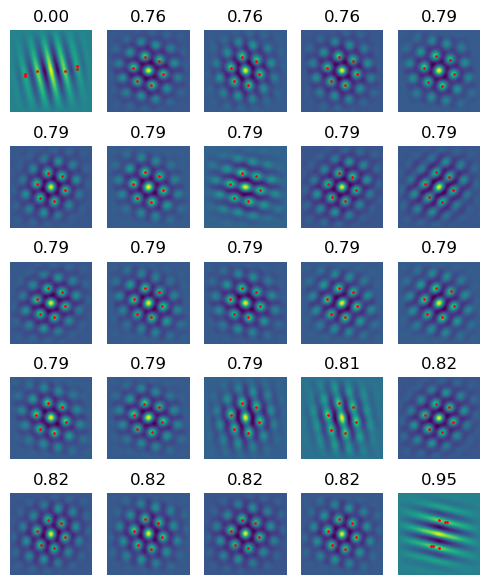

In [12]:
orientation_sorting = np.argsort(thetas)
sorted_maps = acorrs[orientation_sorting]
plot_peaks = [peaks[ind] for ind in orientation_sorting]

ns = 5 # ns x ns grid of unit ratemaps
increment = len(thetas) // (ns**2)
count = 0
fig, ax = plt.subplots(ns,ns, figsize = (5,6))
for i in range(ns**2):
    im = ax[i//ns,i%ns].imshow(sorted_maps[count], origin = "lower")
    ax[i//ns,i%ns].scatter(plot_peaks[count][1:7][:,1], plot_peaks[count][1:7][:,0], c = "r", s = 1)
    ax[i//ns,i%ns].axis("off")
    ax[i//ns,i%ns].set_title(f"{thetas[orientation_sorting][count]%(np.pi/3):.2f}")
    count += increment
plt.tight_layout()

In [13]:
theta_bins = np.linspace(0, np.pi/3, 32, endpoint=False)
counts = np.histogram(thetas, bins = theta_bins)[0]

In [14]:
theta_shift = 6*thetas - np.pi # shift and stretch for von Mises 
v_bins, v_kde = vonmises_kde(theta_shift, 10*np.pi, n_bins = 100)
v_bins = (v_bins + np.pi)/6 # shift back to [0, pi/3]
v_kde = v_kde*6 # re-normalize

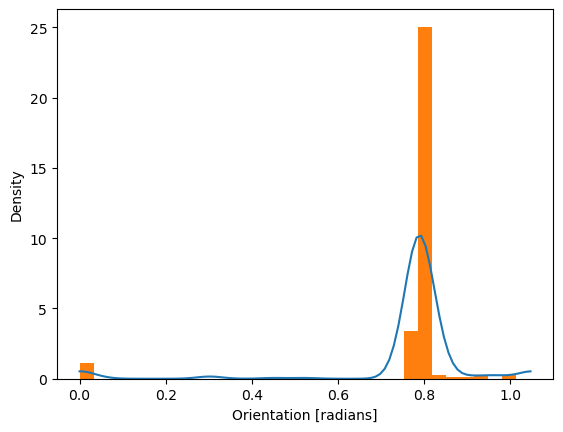

In [15]:
plt.plot(v_bins, v_kde) # revert to [0, pi/3]
plt.hist(thetas, theta_bins, density = True);
plt.xlabel("Orientation [radians]");
plt.ylabel("Density");

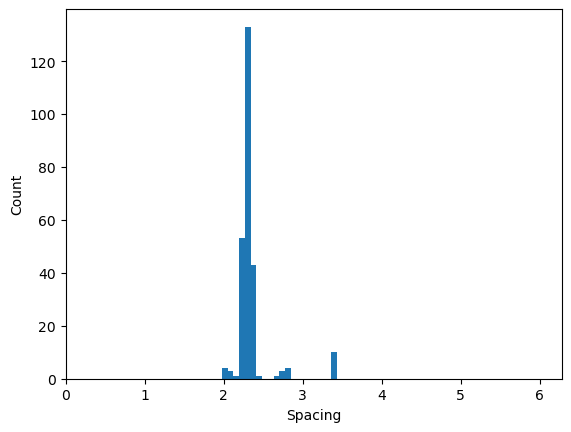

In [16]:
plt.hist(spacings, bins = 20);
plt.xlim([0, 2*np.pi])
plt.xlabel("Spacing");
plt.ylabel("Count");

In [17]:
def phase(peaks, box_size):
    """
    Find phase of pattern
    """
    peaks = np.array(peaks)

    # sort by distance to center
    d = np.linalg.norm(peaks - box_size/2, axis=-1)
    center_peak = peaks[np.argmin(d)]
    return center_peak    

ratemap_peaks = [sm.find_peaks(ratemap) for ratemap in smooth_ratemaps]
phases = np.array([phase(peak, smooth_ratemaps.shape[-1]) for peak in ratemap_peaks])
phases[0].shape, len(phases)
np.save(f"./statistics/{model_type}_Phases.npy", phases)

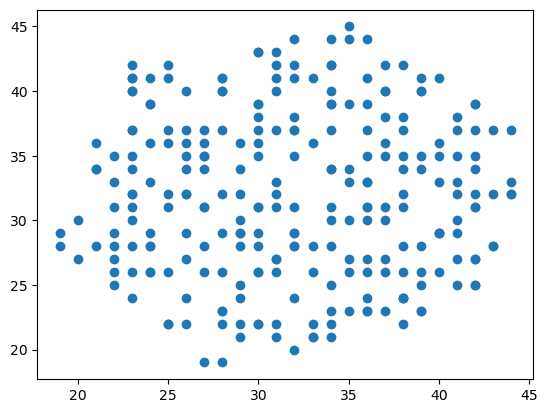

In [18]:
plt.plot(phases[:,0], phases[:,1], "o")

In [19]:
flat = np.stack(phases, axis =0)

In [20]:
kde = scipy.stats.gaussian_kde(phases.T, bw_method = 0.15)
x = np.linspace(np.amin(phases), np.amax(phases), 100)
xx, yy = np.meshgrid(x,x)
rr = np.stack([xx.ravel(), yy.ravel()], axis=-1)
phase_kde = kde(rr.T)
phase_kde.shape, rr.shape

((10000,), (10000, 2))

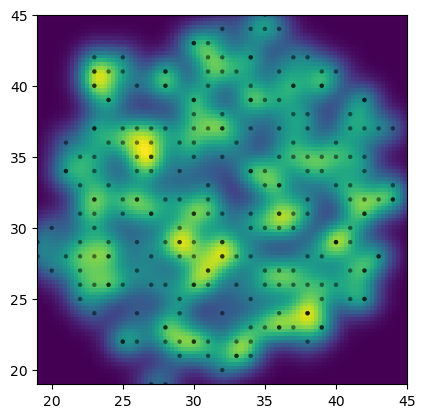

In [21]:
plt.imshow(phase_kde.reshape(100,100), origin = "lower", extent = [np.amin(phases), np.amax(phases), np.amin(phases), np.amax(phases)])
plt.axis("square")
plt.scatter(phases[:,0],phases[:,1], color= "k", s = 10, alpha = 0.5, edgecolors="None")

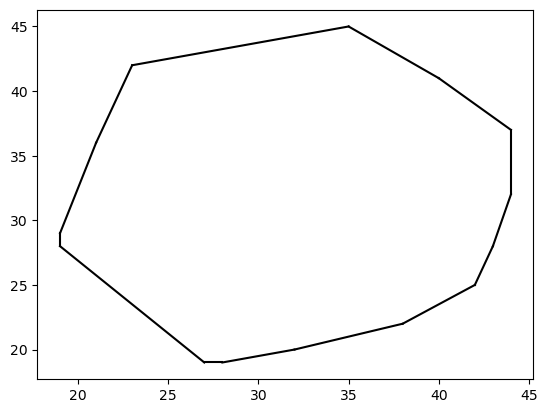

In [22]:
hull = scipy.spatial.ConvexHull(phases)
for simplex in hull.simplices:
    plt.plot(phases[simplex, 0], phases[simplex, 1], 'k-')

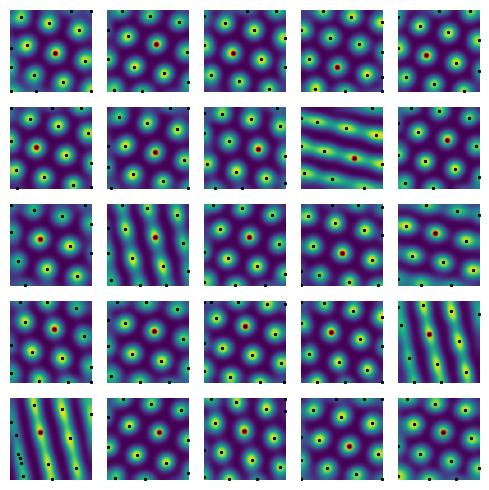

In [23]:
ns = 5 # ns x ns grid of unit ratemaps

increment = len(thetas) // (ns**2)
count = 0
fig, ax = plt.subplots(ns,ns, figsize = (5,5))
for i in range(ns**2):
    im = ax[i//ns,i%ns].imshow(smooth_ratemaps[count], origin = "lower")
    ax[i//ns,i%ns].scatter(phases[count][1], phases[count][0], c = "r", s = 10)
    ax[i//ns,i%ns].scatter(ratemap_peaks[count][:,1], ratemap_peaks[count][:,0], c = "k", s = 2)

    ax[i//ns,i%ns].axis("off")
    count += increment
plt.tight_layout()

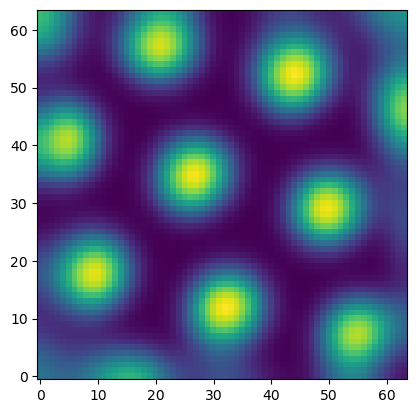

(17.75, 45.25, 17.7, 46.3)

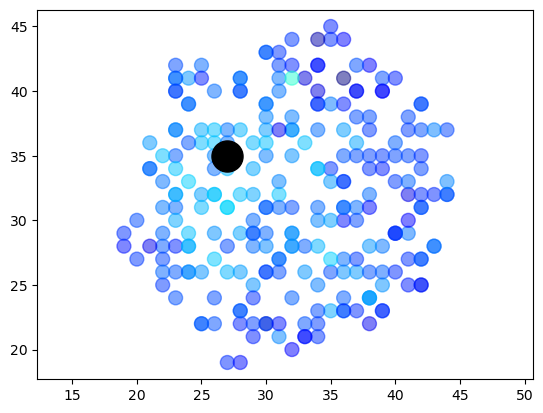

In [24]:
x = np.linspace(np.amin(phases), np.amax(phases), 100)
xx, yy = np.meshgrid(x,x)
rr = np.stack([xx.ravel(), yy.ravel()], axis=-1)

ind = 16
plt.imshow(smooth_ratemaps[ind].T, origin = "lower")
w = model.gg.weight.detach().numpy()[grid_score_mask][:,grid_score_mask].T
plt.show()
plt.scatter(phases[:,0], phases[:,1], c = w[ind], s = 100, cmap = "jet", alpha = 0.5)
plt.scatter(phases[ind,0], phases[ind,1], c = "k",s = 500)
plt.axis("equal")

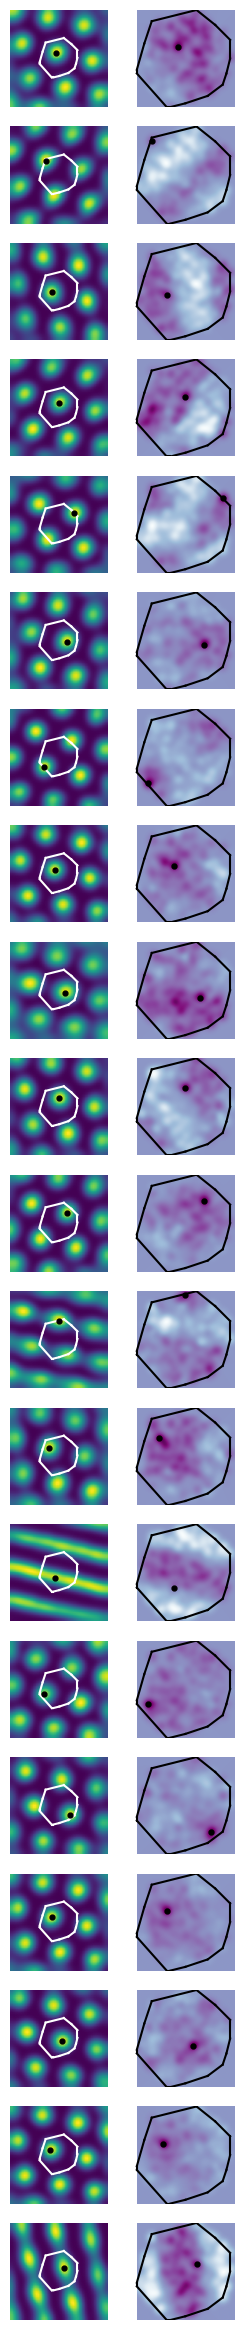

In [40]:
def weighted_kde(mu, w, bw = 1):
    def kernel(x): 
        d = np.sum((mu[None] - x[:,None])**2,axis=-1)
        return np.sum(w[None]*np.exp(-0.5/bw**2*d), axis = 1)
    return kernel

fig, ax = plt.subplots(20,2, figsize = (3, 30))
w = model.gg.weight.detach().numpy()[grid_score_mask][:,grid_score_mask].T

for ind in range(20):
    for simplex in hull.simplices:
        ax[ind,0].plot(phases[simplex, 0], phases[simplex, 1], 'w-')
        ax[ind,1].plot(phases[simplex, 0], phases[simplex, 1], 'k-')

    ax[ind, 0].imshow(smooth_ratemaps[ind].T, origin = "lower")
    kde = weighted_kde(phases, w[ind], bw = 1)
    lim = np.amax(np.abs(kde(rr)))
    im = ax[ind,1].imshow(kde(rr).reshape(100,100), origin = "lower", cmap = "BuPu", vmin = -lim, vmax = lim, 
            extent = [np.amin(phases), np.amax(phases), np.amin(phases), np.amax(phases)])
    ax[ind,1].plot(phases[ind,0], phases[ind,1], "k.", markersize = 7)
    ax[ind,0].plot(phases[ind,0], phases[ind,1], "k.", markersize = 7)

    ax[ind][0].axis("off")
    ax[ind][1].axis("off")
    ax[ind, 1].axis("equal")
    # fig.colorbar(im, fraction = 0.045)
    # plt.show()